In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import cv2

import datetime
%load_ext tensorboard



In [2]:
!rm -rf ./logs/

In [4]:
# There are multiple callbacks that we can use as per our requirements.
# I have used two callbacks, one is the tensorboard which helps visualize the model and another is earlystopping to save the best model 

# class myCallbacks(tf.keras.callbacks.Callback):
#     def on_epoch_end(self,epochs,logs={}):
#         if logs.get("loss") < 0.4:
#             print("loss is less than o.4 stopping training")
#             self.model.stop_training = True

data_path = './archive/indoorCVPR_09/Images/'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlyStopping = tf.keras.callbacks.ModelCheckpoint(filepath="auto_encoder.h5",save_weights_only=False,monitor="val_loss", mode="min", save_best_only=True)
#EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', save_)

I'm using just a simple gausian blur using OpenCV to distort the images but this can also be used with different other distortion features available in OpenCV

In [5]:
def pre_process(image):
    dist_image = cv2.GaussianBlur(image,(11,11),cv2.BORDER_DEFAULT)
    return dist_image

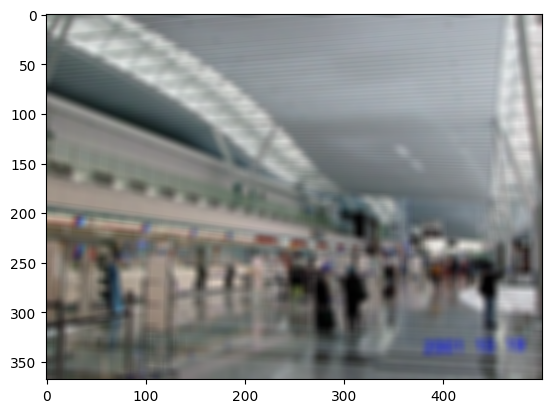

In [6]:
img = pre_process(cv2.imread('./archive/indoorCVPR_09/Images/airport_inside/airport_inside_0001.jpg'))
plt.imshow(img)
plt.show()

In [7]:
datagen = image.ImageDataGenerator(rescale=(1./255),preprocessing_function=pre_process,validation_split=0.2)

train_datagen = datagen.flow_from_directory(data_path, 
                        target_size=(224,224),
                        class_mode= 'input',
                        batch_size=32,
                        subset='training')

val_datagen = datagen.flow_from_directory(data_path, 
                        target_size=(224,224),
                        class_mode= 'input',
                        batch_size=32,
                        subset='validation')

Found 12522 images belonging to 67 classes.
Found 3098 images belonging to 67 classes.


### There are 3 types of padding which can be used while defining a convolutional layer
1. Same Padding - zeros are added at the outter frame so that even the broder pixels are taken into consideration while applying filters
2. Valid Padding - this generally means we are not adding anything to the border or edges of the matrix
3. Causal Padding - this is for one dimensional convolutional layer in which a zero is added in the start of the data

* Caluclating number of output size using paddings
1. Same Padding = Height of the filter X Stride
2. Valid Padding = (Height of filter -1) X stride


In [9]:
auto_encoder = tf.keras.models.Sequential([
    Conv2D(32,(3,3),input_shape=(224,224,3),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128,(3,3),activation='relu'),
    MaxPool2D(2,2),    
    Conv2DTranspose(128,(4,4),strides=2, padding='valid', activation='relu'),
    Conv2DTranspose(64,(4,4),strides=2, padding='valid',activation='relu'),
    Conv2DTranspose(32,(4,4),strides=2, padding='valid', activation='relu'),
    Conv2DTranspose(32,(4,4),strides=2, padding='valid',activation='relu'),
    Conv2DTranspose(3,(3,3),strides=1, padding='valid',activation='sigmoid')   
])

auto_encoder.compile(optimizer='adam',loss='mae')
auto_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [10]:
history = auto_encoder.fit(train_datagen,epochs=10,validation_data=val_datagen,batch_size=16, callbacks=[tensorboard_callback,earlyStopping])

Epoch 1/10


2022-09-27 17:31:27.085754: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


392/392 [==============================] - ETA: 0s - loss: 0.0818

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 309s 787ms/step - loss: 0.0818 - val_loss: 0.0470
Epoch 2/10
392/392 [==============================] - ETA: 0s - loss: 0.0416

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 282s 718ms/step - loss: 0.0416 - val_loss: 0.0372
Epoch 3/10
392/392 [==============================] - ETA: 0s - loss: 0.0357

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 282s 720ms/step - loss: 0.0357 - val_loss: 0.0353
Epoch 4/10
392/392 [==============================] - ETA: 0s - loss: 0.0334

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 273s 696ms/step - loss: 0.0334 - val_loss: 0.0310
Epoch 5/10
392/392 [==============================] - ETA: 0s - loss: 0.0320

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 278s 708ms/step - loss: 0.0320 - val_loss: 0.0291
Epoch 6/10
392/392 [==============================] - 284s 724ms/step - loss: 0.0303 - val_loss: 0.0312
Epoch 7/10
392/392 [==============================] - ETA: 0s - loss: 0.0293

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 272s 694ms/step - loss: 0.0293 - val_loss: 0.0278
Epoch 8/10
392/392 [==============================] - 273s 695ms/step - loss: 0.0287 - val_loss: 0.0280
Epoch 9/10
392/392 [==============================] - ETA: 0s - loss: 0.0282

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 1560s 4s/step - loss: 0.0282 - val_loss: 0.0267
Epoch 10/10
392/392 [==============================] - ETA: 0s - loss: 0.0276

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


392/392 [==============================] - 282s 720ms/step - loss: 0.0276 - val_loss: 0.0265


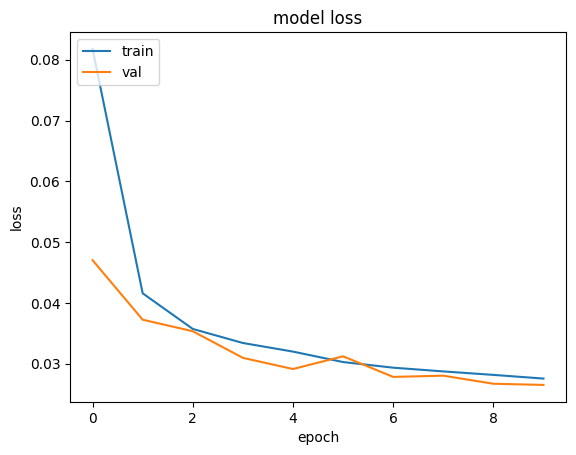

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
#auto_encoder.save('auto_encoder.h5')

In [13]:
def test_model(img_path):
    fig = plt.figure(figsize=(10, 7))
    

    test_image = cv2.imread(img_path)
    test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB) 

    test_image_distorted = pre_process(test_image)

    tmp = cv2.resize(test_image_distorted,(224,224))
    tmp = (np.expand_dims(tmp,axis=0))/255
    test_image_predicted = auto_encoder.predict(tmp)

    fig.add_subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.axis('off')
    plt.title("Original Image")

    fig.add_subplot(1, 3, 2)
    plt.imshow(test_image_distorted)
    plt.axis('off')
    plt.title("Distorted Image")

    fig.add_subplot(1, 3, 3)
    plt.imshow(test_image_predicted[0])
    plt.axis('off')
    plt.title("Reconstructed Image")

    plt.show()

1/1 [==============================] - 0s 129ms/step


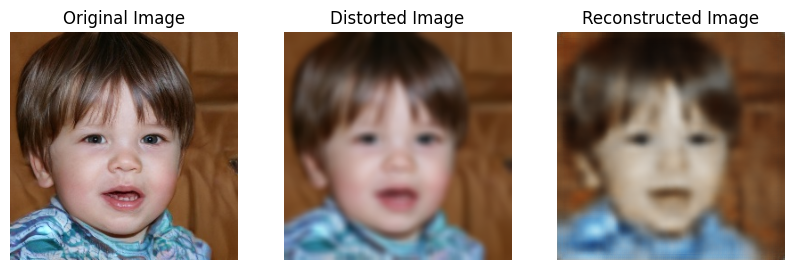

In [14]:
test_model('archive/Test_2.jpeg')

1/1 [==============================] - 0s 27ms/step


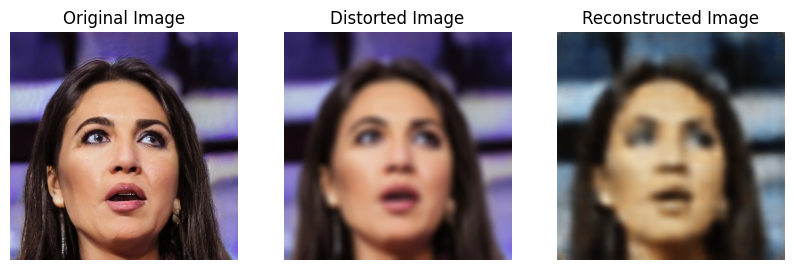

In [15]:
test_model('archive/Test_1.jpeg')

1/1 [==============================] - 0s 33ms/step


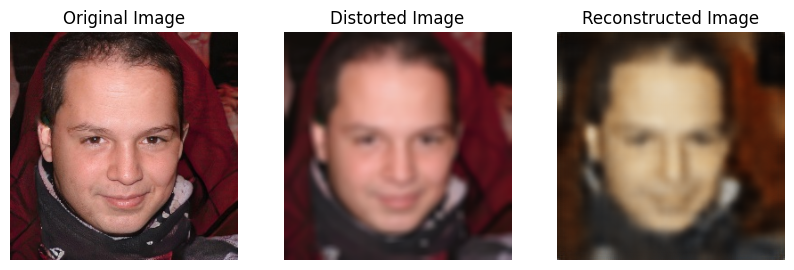

In [16]:
test_model('archive/Test_3.jpeg')